In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import scipy.stats as ss
from numpy import genfromtxt    
from brainspace.datasets import load_conte69
from brainspace.plotting import plot_hemispheres
from brainspace.utils.parcellation import map_to_labels
import matplotlib.pyplot as plt
import seaborn as sns

### read in the Asymmetry Index (AI) and its Heritability for human data

In [2]:
def fdr(p_vals):
    from scipy.stats import rankdata
    ranked_p_values = rankdata(p_vals)
    fdr = p_vals * len(p_vals) / ranked_p_values
    fdr[fdr > 1] = 1
    return fdr

In [3]:
intra_AI_g1_mean = np.array(pd.read_csv('../data/data_results/gradient/mean_asym_LLRR.csv',header=None))[:,0]
intra_AI_g1_fdr = np.array(pd.read_csv('../data/data_results/gradient/g_stats_fdr.csv')['intra_g1_fdr'])
inter_AI_g1_mean = np.array(pd.read_csv('../data/data_results/gradient/mean_asym_LRRL.csv',header=None))[:,0]
inter_AI_g1_fdr = np.array(pd.read_csv('../data/data_results/gradient/g_stats_fdr.csv')['inter_g1_fdr'])
intra_AI_g1_h2 = np.array(pd.read_csv('../data/data_results/solar/LL-RR/G1/G1_results_herit.csv')['H2r'])
intra_AI_g1_h2p = np.array(pd.read_csv('../data/data_results/solar/LL-RR/G1/G1_results_herit.csv')['rp'])
inter_AI_g1_h2 = np.array(pd.read_csv('../data/data_results/solar/LR-RL/G1/G1_results_herit.csv')['H2r'])
inter_AI_g1_h2p = np.array(pd.read_csv('../data/data_results/solar/LR-RL/G1/G1_results_herit.csv')['rp'])
intra_AI_g1_h2fdr = fdr(intra_AI_g1_h2p)
inter_AI_g1_h2fdr = fdr(inter_AI_g1_h2p)

## spin permutation

In [5]:
def spin_human_spearman(x,y):
  # x, y should be one array 
  from brainspace.null_models import SampledSurrogateMaps
  n_surrogate_datasets = 1000

  # Note: number samples must be greater than number neighbors
  num_samples = 40
  num_neighbors = 20
  from scipy.sparse.csgraph import dijkstra
  distance= dijkstra(np.array(pd.read_csv('../data/LeftParcelGeodesicDistmat.txt',
                                          header=None, delimiter=' ')), directed=False)
  distance_idx_sorted = np.argsort(distance, axis=1)
  ssm = SampledSurrogateMaps(ns=num_samples, knn=num_samples, random_state=0,resample=True)
  ssm.fit(distance, distance_idx_sorted)
  x_surrogates = ssm.randomize(x, n_rep=n_surrogate_datasets)
  surrogate_corrs = spearmanr(y, x_surrogates).flatten()
  r_stat = spearmanr(x, y)[0]
  from brainsmash.mapgen.stats import nonparp
  p = nonparp(r_stat, surrogate_corrs)
  return print('spearmanr = '+ str(r_stat), 'p_value_spin = ', str(p))
def spin_human_pearson(x,y):
  # x, y should be one array 
  from brainspace.null_models import SampledSurrogateMaps
  n_surrogate_datasets = 1000

  # Note: number samples must be greater than number neighbors
  num_samples = 40
  num_neighbors = 20
  from scipy.sparse.csgraph import dijkstra
  distance= dijkstra(np.array(pd.read_csv('../data/LeftParcelGeodesicDistmat.txt',
                                          header=None, delimiter=' ')), directed=False)
  distance_idx_sorted = np.argsort(distance, axis=1)
  ssm = SampledSurrogateMaps(ns=num_samples, knn=num_samples, random_state=0,resample=True)
  ssm.fit(distance, distance_idx_sorted)
  x_surrogates = ssm.randomize(x, n_rep=n_surrogate_datasets)
  from brainsmash.mapgen.stats import pearsonr
  surrogate_corrs = pearsonr(y, x_surrogates).flatten()
  r_stat = pearsonr(x, y)[0]
  from brainsmash.mapgen.stats import nonparp
  p = nonparp(r_stat, surrogate_corrs)
  return print('pearsonr = '+ str(r_stat), 'p_value_spin = ', str(p))

### correlations between intra-g1 and inter-g1

In [6]:
[ss.spearmanr(intra_AI_g1_mean,inter_AI_g1_mean),
 spin_human_spearman(intra_AI_g1_mean,inter_AI_g1_mean)]

spearmanr = [0.64483472] p_value_spatial =  0.0
spearmanr = [0.64483472] p_value_spin =  0.0


[SpearmanrResult(correlation=0.6448347171208988, pvalue=1.5365316739292306e-22),
 None,
 None]

### plot AI-score (x-axis) versus  its heritability (y-axis)

In [7]:
ca = np.array(pd.read_csv('../data/ca_glasser_network.csv',header=None))[:,0].astype(float)
color = ca[:180]
from matplotlib.colors import ListedColormap
import hcp_utils as hcp
cmap = ListedColormap(np.vstack((list(hcp.ca_network['rgba'].values())))[1:])

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


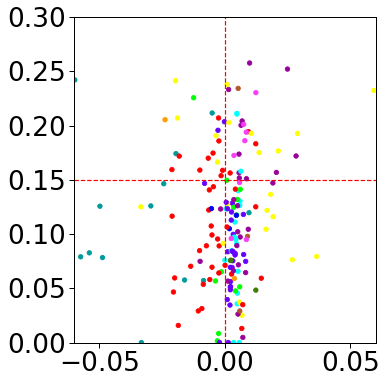

In [8]:
sns.set_context("paper", font_scale = 3)
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(-intra_AI_g1_mean, intra_AI_g1_h2, s = 20, c = color, cmap=cmap, marker = 'o')
ax.set_xlim(-0.06, 0.06)
ax.set_ylim(0, 0.3)
ax.grid(False)
ax.axvline(x=0, color='r', linestyle='--')
ax.axhline(y=0.15,color='r', linestyle='--')
fig.tight_layout()
fig.savefig('../figures/fig_23_intra_mean_h2_g1.svg')

pearsonr = [0.24494087] p_value_spin =  0.005
spearmanr = [0.17601753] p_value_spin =  0.058


[(0.2449408731896262, 0.0009198432052935741),
 SpearmanrResult(correlation=0.176017531594978, pvalue=0.01810055187208939),
 None,
 None]

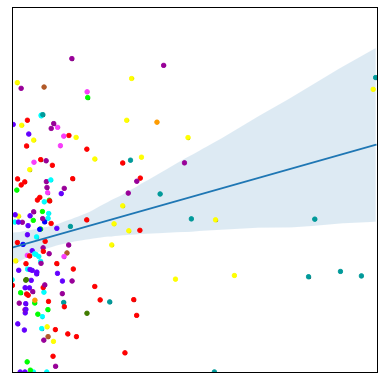

In [9]:
sns.set_context("paper", font_scale = 3)
fig, ax = plt.subplots(figsize=(6,6))
sns.regplot(abs(intra_AI_g1_mean), intra_AI_g1_h2,
            ax = ax, scatter_kws={'s': 5, 'color': 'black'})
ax.scatter(abs(intra_AI_g1_mean), intra_AI_g1_h2, s = 20, c = color, cmap=cmap, marker = 'o')
ax.set_xlim(0, 0.06)
ax.set_ylim(0, 0.3)
ax.set_xticks([])
ax.set_yticks([])
ax.grid(False)
fig.tight_layout()
fig.savefig('../figures/fig_23_intra_mean_h2_g1_abs.svg')

[ss.pearsonr(abs(intra_AI_g1_mean), intra_AI_g1_h2),
 ss.spearmanr(abs(intra_AI_g1_mean), intra_AI_g1_h2),
 spin_human_pearson(abs(intra_AI_g1_mean),intra_AI_g1_h2),
 spin_human_spearman(abs(intra_AI_g1_mean),intra_AI_g1_h2)]

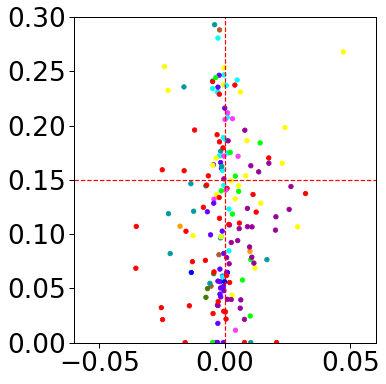

In [10]:
sns.set_context("paper", font_scale = 3)
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(-inter_AI_g1_mean, inter_AI_g1_h2, s = 20, c = color, cmap=cmap, marker = 'o')
ax.set_xlim(-0.06, 0.06)
ax.set_ylim(0, 0.3)
ax.grid(False)
ax.axvline(x=0, color='r', linestyle='--')
ax.axhline(y=0.15,color='r', linestyle='--')
fig.tight_layout()
fig.savefig('../figures/fig_23_inter_mean_h2_g1.svg')

spearmanr = [-0.01631785] p_value_spin =  0.888
pearsonr = [0.0552122] p_value_spin =  0.613


[SpearmanrResult(correlation=-0.01631784613339196, pvalue=0.8278840463984951),
 (0.05521220199062758, 0.4616390630139903),
 None,
 None]

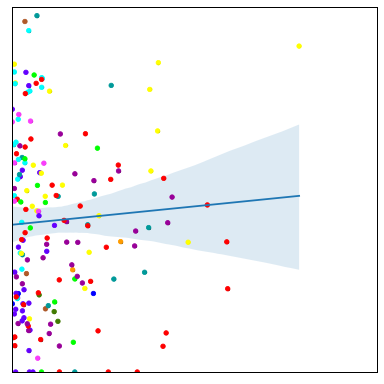

In [11]:
sns.set_context("paper", font_scale = 3)
fig, ax = plt.subplots(figsize=(6,6))
sns.regplot(abs(inter_AI_g1_mean), inter_AI_g1_h2,
            ax = ax, scatter_kws={'s': 5, 'color': 'black'})
ax.scatter(abs(inter_AI_g1_mean), inter_AI_g1_h2, s = 20, c = color, cmap=cmap, marker = 'o')
ax.set_xlim(0, 0.06)
ax.set_ylim(0, 0.3)
ax.set_xticks([])
ax.set_yticks([])
ax.grid(False)
fig.tight_layout()
fig.savefig('../figures/fig_23_inter_mean_h2_g1_abs.svg')

[ss.spearmanr(abs(inter_AI_g1_mean), inter_AI_g1_h2),
 ss.pearsonr(abs(inter_AI_g1_mean), inter_AI_g1_h2),
 spin_human_spearman(abs(inter_AI_g1_mean),inter_AI_g1_h2),
 spin_human_pearson(abs(inter_AI_g1_mean),inter_AI_g1_h2)]

### plot AI-scores of gradients across cortex

In [12]:
surf_lh, surf_rh = load_conte69()

glasser = '../data/glasser.csv'
glasser = genfromtxt(glasser)

glasser_r = glasser[32492:]
glasser_l = glasser[:32492]
glasser_r[glasser_r == 180] = 0

glasser = np.concatenate((glasser_l, glasser_r))

labeling = glasser.copy()

mymask = labeling != 0

In [13]:
intra_AI_g1_mean = map_to_labels(np.concatenate((intra_AI_g1_mean,-intra_AI_g1_mean)), labeling, mask=mymask)
intra_AI_g1_mean[np.where(intra_AI_g1_mean==0)] = np.nan
intra_AI_g1_fdr = map_to_labels(np.concatenate((intra_AI_g1_fdr,intra_AI_g1_fdr)), labeling, mask=mymask)
intra_AI_g1_fdr[np.where(intra_AI_g1_fdr==0)] = np.nan

inter_AI_g1_mean = map_to_labels(np.concatenate((inter_AI_g1_mean,-inter_AI_g1_mean)), labeling, mask=mymask)
inter_AI_g1_mean[np.where(inter_AI_g1_mean==0)] = np.nan
inter_AI_g1_fdr = map_to_labels(np.concatenate((inter_AI_g1_fdr,inter_AI_g1_fdr)), labeling, mask=mymask)
inter_AI_g1_fdr[np.where(inter_AI_g1_fdr==0)] = np.nan

In [14]:
intra_AI_g1_h2[np.where(intra_AI_g1_h2==0)] = 1 # h2 < 0.3
intra_AI_g1_h2 = map_to_labels(np.concatenate((intra_AI_g1_h2,intra_AI_g1_h2)), labeling, mask=mymask)
intra_AI_g1_h2[np.where(intra_AI_g1_h2==0)] = np.nan
intra_AI_g1_h2[np.where(intra_AI_g1_h2==1)] = 0

intra_AI_g1_h2fdr = map_to_labels(np.concatenate((intra_AI_g1_h2fdr,intra_AI_g1_h2fdr)), labeling, mask=mymask)
intra_AI_g1_h2fdr[np.where(intra_AI_g1_h2fdr==0)] = np.nan

inter_AI_g1_h2[np.where(inter_AI_g1_h2==0)] = 1
inter_AI_g1_h2 = map_to_labels(np.concatenate((inter_AI_g1_h2,inter_AI_g1_h2)), labeling, mask=mymask)
inter_AI_g1_h2[np.where(inter_AI_g1_h2==0)] = np.nan
inter_AI_g1_h2[np.where(inter_AI_g1_h2==1)] = 0

inter_AI_g1_h2fdr = map_to_labels(np.concatenate((inter_AI_g1_h2fdr,inter_AI_g1_h2fdr)), labeling, mask=mymask)
inter_AI_g1_h2fdr[np.where(inter_AI_g1_h2fdr==0)] = np.nan

### intra-hemispheric AI for Gradient 1

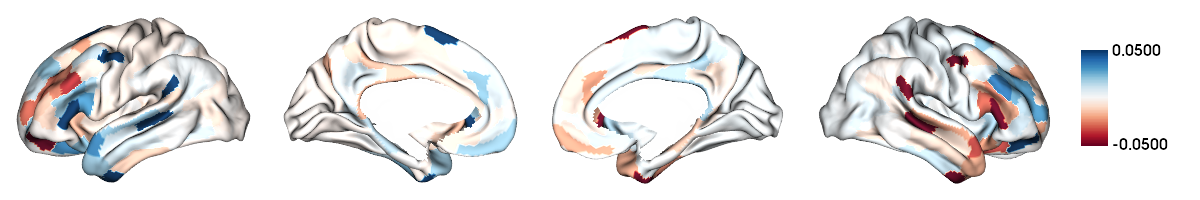

In [15]:
plot_hemispheres(surf_lh, surf_rh, array_name = np.array(intra_AI_g1_mean,dtype=float),
                 nan_color = (1,1,1,0.01),size = (1200, 200),
                 cmap = 'RdBu', color_bar = True, color_range = (-0.05, 0.05),
                 interactive = False, zoom = 1.5, embed_nb = True,
                 screenshot=True, filename='../figures/fig_23_intra_ai_g1_mean.svg',transparent_bg=True,scale=(2,2))
plot_hemispheres(surf_lh, surf_rh, array_name = np.array(intra_AI_g1_mean,dtype=float),
                 nan_color = (1,1,1,0.01),size = (1200, 200),
                 cmap = 'RdBu', color_bar = True, color_range = (-0.05, 0.05),
                 interactive = False, zoom = 1.5, embed_nb = True)

### inter-hemispheric AI for Gradient 1

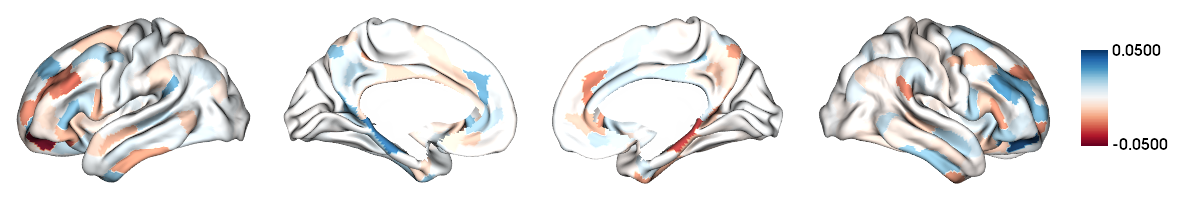

In [17]:
plot_hemispheres(surf_lh, surf_rh, array_name = np.array(inter_AI_g1_mean,dtype=float),
                 nan_color = (1,1,1,0.01),size = (1200, 200),
                 cmap = 'RdBu', color_bar = True, color_range = (-0.05, 0.05),
                 interactive = False, zoom = 1.5, embed_nb = True,
                 screenshot=True, filename='../figures/fig_23_inter_ai_g1_mean.svg')
plot_hemispheres(surf_lh, surf_rh, array_name = np.array(inter_AI_g1_mean,dtype=float),
                 nan_color = (1,1,1,0.01),size = (1200, 200),
                 cmap = 'RdBu', color_bar = True, color_range = (-0.05, 0.05),
                 interactive = False, zoom = 1.5, embed_nb = True)

### plot FDR-corrected p-values for intra-hemispheric AI scores

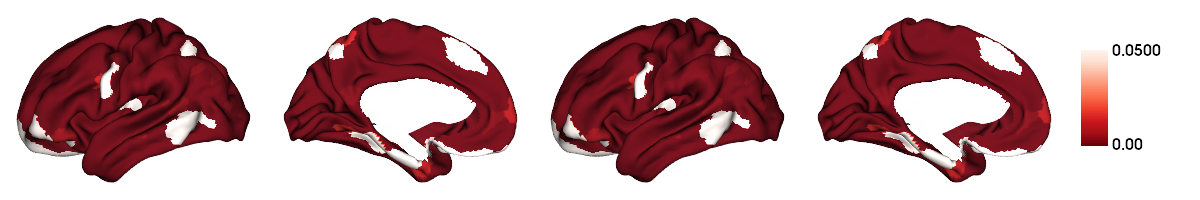

In [18]:
plot_hemispheres(surf_lh, surf_lh, array_name = np.array(intra_AI_g1_fdr,dtype=float),
                 nan_color = (1,1,1,0.01),size = (1200, 200),
                 cmap = 'Reds_r', color_bar = True, color_range = (0, 0.05),
                 interactive = False, zoom = 1.5, embed_nb = True,
                 screenshot=True, filename='../figures/fig_23_intra_ai_g1_fdr.svg')
plot_hemispheres(surf_lh, surf_lh, array_name = np.array(intra_AI_g1_fdr,dtype=float),
                 nan_color = (1,1,1,0.01),size = (1200, 200),
                 cmap = 'Reds_r', color_bar = True, color_range = (0, 0.05),
                 interactive = False, zoom = 1.5, embed_nb = True)

### plot FDR-corrected p-values for inter-hemispheric AI scores

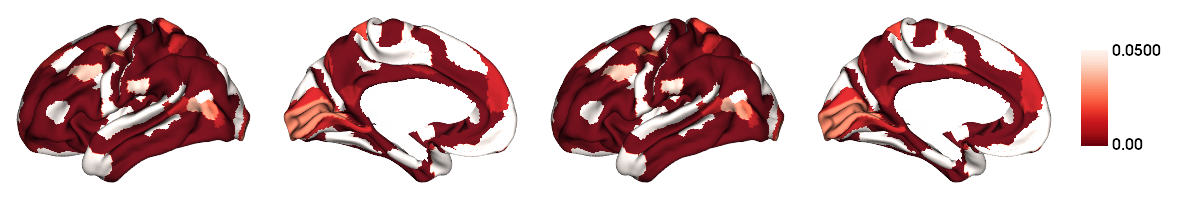

In [19]:
plot_hemispheres(surf_lh, surf_lh, array_name = np.array(inter_AI_g1_fdr,dtype=float),
                 nan_color = (1,1,1,0.01),size = (1200, 200),
                 cmap = 'Reds_r', color_bar = True, color_range = (0, 0.05),
                 interactive = False, zoom = 1.5, embed_nb = True,
                 screenshot=True, filename='../figures/fig_23_inter_ai_g1_fdr.svg')
plot_hemispheres(surf_lh, surf_lh, array_name = np.array(inter_AI_g1_fdr,dtype=float),
                 nan_color = (1,1,1,0.01),size = (1200, 200),
                 cmap = 'Reds_r', color_bar = True, color_range = (0, 0.05),
                 interactive = False, zoom = 1.5, embed_nb = True)

### plot heritability of intra-hemispheric AI (G1) scores

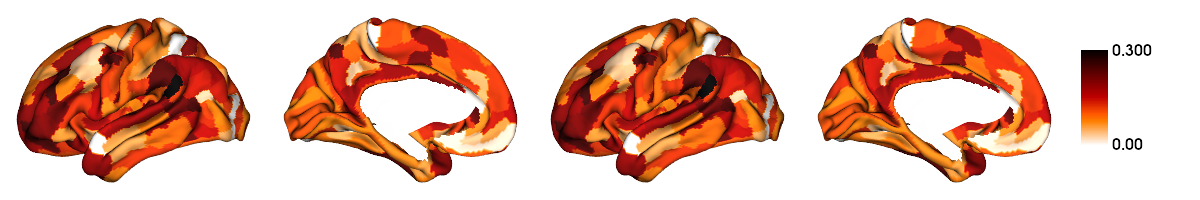

In [20]:
plot_hemispheres(surf_lh, surf_lh, array_name = np.array(intra_AI_g1_h2,dtype=float),
                 nan_color = (1,1,1,0.01),size = (1200, 200),
                 cmap = 'gist_heat_r', color_bar = True, color_range = (0, 0.3),
                 interactive = False, zoom = 1.5, embed_nb = True,
                 screenshot=True, filename='../figures/fig_23_intra_ai_g1_h2.svg')
plot_hemispheres(surf_lh, surf_lh, array_name = np.array(intra_AI_g1_h2,dtype=float),
                 nan_color = (1,1,1,0.01),size = (1200, 200),
                 cmap = 'gist_heat_r', color_bar = True, color_range = (0, 0.3),
                 interactive = False, zoom = 1.5, embed_nb = True)

### plot heritability of inter-hemispheric AI (G1) scores

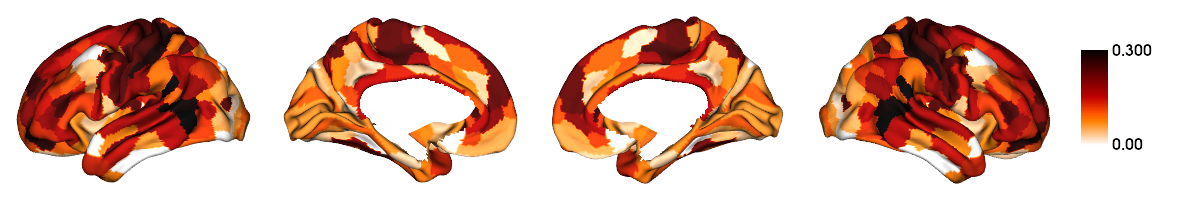

In [21]:
plot_hemispheres(surf_lh, surf_rh, array_name = np.array(inter_AI_g1_h2,dtype=float),
                 nan_color = (1,1,1,0.01),size = (1200, 200),
                 cmap = 'gist_heat_r', color_bar = True, color_range = (0, 0.3),
                 interactive = False, zoom = 1.5, embed_nb = True,
                 screenshot=True, filename='../figures/fig_23_inter_ai_g1_h2.svg')
plot_hemispheres(surf_lh, surf_rh, array_name = np.array(inter_AI_g1_h2,dtype=float),
                 nan_color = (1,1,1,0.01),size = (1200, 200),
                 cmap = 'gist_heat_r', color_bar = True, color_range = (0, 0.3),
                 interactive = False, zoom = 1.5, embed_nb = True)

### pFDR for heritability (intra G1)

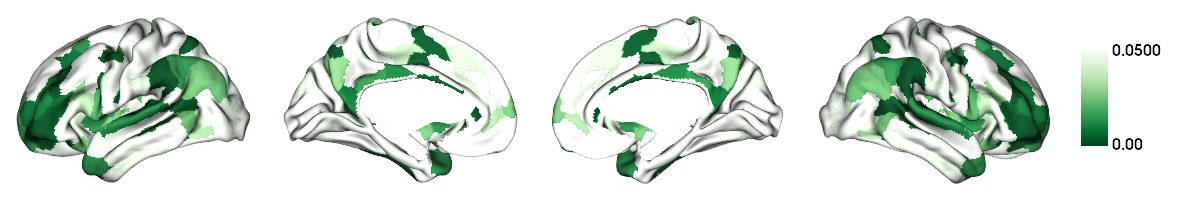

In [22]:
plot_hemispheres(surf_lh, surf_rh, array_name = np.array(intra_AI_g1_h2fdr,dtype=float),
                 nan_color = (1,1,1,0.01),size = (1200, 200),
                 cmap = 'Greens_r', color_bar = True, color_range = (0, 0.05),
                 interactive = False, zoom = 1.5, embed_nb = True,
                 screenshot=True, filename='../figures/fig_23_intra_ai_g1_h2fdr.svg')
plot_hemispheres(surf_lh, surf_rh, array_name = np.array(intra_AI_g1_h2fdr,dtype=float),
                 nan_color = (1,1,1,0.01),size = (1200, 200),
                 cmap = 'Greens_r', color_bar = True, color_range = (0, 0.05),
                 interactive = False, zoom = 1.5, embed_nb = True)

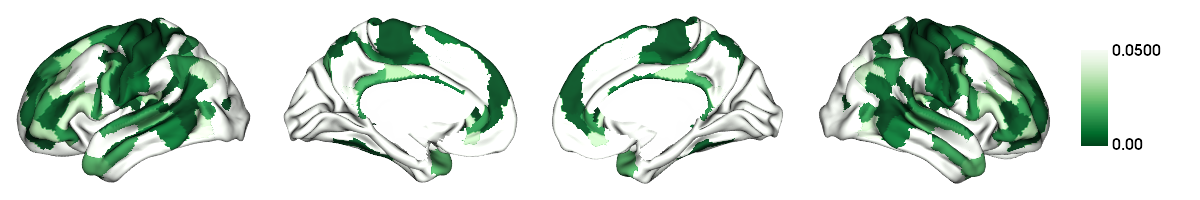

In [23]:
plot_hemispheres(surf_lh, surf_rh, array_name = np.array(inter_AI_g1_h2fdr,dtype=float),
                 nan_color = (1,1,1,0.01),size = (1200, 200),
                 cmap = 'Greens_r', color_bar = True, color_range = (0, 0.05),
                 interactive = False, zoom = 1.5, embed_nb = True,
                 screenshot=True, filename='../figures/fig_23_inter_ai_g1_h2fdr.svg')
plot_hemispheres(surf_lh, surf_rh, array_name = np.array(inter_AI_g1_h2fdr,dtype=float),
                 nan_color = (1,1,1,0.01),size = (1200, 200),
                 cmap = 'Greens_r', color_bar = True, color_range = (0, 0.05),
                 interactive = False, zoom = 1.5, embed_nb = True)

## Cole-Anticevic Network

In [24]:
import os
path = '../data/data_results/gradient/intra_ca/'
path_list = os.listdir(path)
path_list.sort()

ca_l = np.array(pd.read_csv('../data/ca_glasser_network.csv',header=None))[:,0][:180]
ca_r = np.array(pd.read_csv('../data/ca_glasser_network.csv',header=None))[:,0][180:]

In [25]:
intra= [None] * 1014
for i in range(1014):
    intra[i] = np.array(pd.read_csv(path+path_list[i],header=None))

In [26]:
import hcp_utils as hcp
hcp.ca_network

{'ids': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 'map_all': array([9, 3, 6, ..., 7, 7, 7]),
 'labels': {0: '',
  1: 'Visual1',
  2: 'Visual2',
  3: 'Somatomotor',
  4: 'Cingulo-Opercular',
  5: 'Dorsal-attention',
  6: 'Language',
  7: 'Frontoparietal',
  8: 'Auditory',
  9: 'Default',
  10: 'Posterior-Multimodal',
  11: 'Ventral-Multimodal',
  12: 'Orbito-Affective'},
 'rgba': {0: array([1., 1., 1., 0.]),
  1: array([0., 0., 1., 1.]),
  2: array([0.392157, 0.      , 1.      , 1.      ]),
  3: array([0., 1., 1., 1.]),
  4: array([0.6, 0. , 0.6, 1. ]),
  5: array([0., 1., 0., 1.]),
  6: array([0.      , 0.603922, 0.603922, 1.      ]),
  7: array([1., 1., 0., 1.]),
  8: array([0.976471, 0.239216, 0.984314, 1.      ]),
  9: array([1., 0., 0., 1.]),
  10: array([0.694118, 0.34902 , 0.156863, 1.      ]),
  11: array([1.      , 0.611765, 0.      , 1.      ]),
  12: array([0.254902, 0.486275, 0.      , 1.      ])},
 'nontrivial_ids': array([ 1,  2,  3,  4,  5,  6,  7,  8,

In [27]:
from matplotlib.colors import ListedColormap

color =  [[0.      , 0.603922, 0.603922, 1.      ],
          [1., 0., 0., 1.],
          [1.      , 0.611765, 0.      , 1.      ],
          [0., 0., 1., 1.],
          [0.392157, 0.      , 1.      , 1.      ],
          [0., 1., 1., 1.],
          [0.254902, 0.486275, 0.      , 1.      ],
          [0., 1., 0., 1.],
          [0.694118, 0.34902 , 0.156863, 1.      ],
          [0.976471, 0.239216, 0.984314, 1.      ],
          [0.6, 0. , 0.6, 1. ],
          [1., 1., 0., 1.]]

cmap = ListedColormap(color)

In [28]:
base_color = sns.color_palette(color)
print(np.array(intra).T[0].T.shape)
#base_color

(1014, 12)


In [29]:
intra_g1 = np.array(intra).T[0].T
intra_g1.shape

(1014, 12)

### ca network intra-hemisphere G1

In [30]:
df_intra = np.concatenate((intra_g1[:,5],intra_g1[:,8],intra_g1[:,10],intra_g1[:,0],
                           intra_g1[:,1],intra_g1[:,2],intra_g1[:,11],intra_g1[:,4],
                           intra_g1[:,9],intra_g1[:,7],intra_g1[:,3],intra_g1[:,6]))
network = np.concatenate((['Language']*1014,['Default']*1014,['Ventral-Multimodal']*1014,
                          ['Primary Visual'] * 1014, ['Secondary Visual'] *1014,['Somatomotor']*1014,
                          ['Orbito-Affective']*1014,['Dorsal-attention']*1014,['Posterior-Multimodal']*1014,
                          ['Auditory']*1014,['Cingulo-Opercular']*1014,['Frontoparietal']*1014))

pd.DataFrame(np.vstack((-df_intra,network)).T, 
             columns = ['AI','Network']).to_csv('../data/data_results/gradient/ca_intra_g1.csv',index=None)

df = pd.read_csv('../data/data_results/gradient/ca_intra_g1.csv')

### one sample t-test

In [31]:
from scipy import stats
sts=np.array([stats.ttest_1samp(intra_g1[:,0],0),
     stats.ttest_1samp(intra_g1[:,1],0),
     stats.ttest_1samp(intra_g1[:,2],0),
     stats.ttest_1samp(intra_g1[:,3],0),
     stats.ttest_1samp(intra_g1[:,4],0),
     stats.ttest_1samp(intra_g1[:,5],0),
     stats.ttest_1samp(intra_g1[:,6],0),
     stats.ttest_1samp(intra_g1[:,7],0),
     stats.ttest_1samp(intra_g1[:,8],0),
     stats.ttest_1samp(intra_g1[:,9],0),
     stats.ttest_1samp(intra_g1[:,10],0),
     stats.ttest_1samp(intra_g1[:,11],0)])
sts

array([[ 1.92652625e+000,  5.43182061e-002],
       [ 1.22113168e+000,  2.22320296e-001],
       [-4.64098541e+000,  3.92227877e-006],
       [-1.60751112e+001,  5.80777528e-052],
       [-5.38582803e+000,  8.96502001e-008],
       [ 4.13338246e+001,  1.29372063e-219],
       [-2.59998451e+001,  1.39652230e-114],
       [-9.57460121e+000,  7.55467338e-021],
       [ 1.73485476e+001,  3.12558322e-059],
       [-8.26023296e+000,  4.51063349e-016],
       [ 7.99885986e+000,  3.41374558e-015],
       [-4.71228277e+000,  2.79132151e-006]])

In [32]:
fdr(sts[:,1])

array([5.92562249e-002, 2.22320296e-001, 4.70673452e-006, 1.74233258e-051,
       1.34475300e-007, 1.55246475e-218, 8.37913379e-114, 1.81312161e-020,
       1.25023329e-058, 9.02126698e-016, 5.85213527e-015, 3.72176202e-006])

### plot CA intra-hemispheric AI along G1

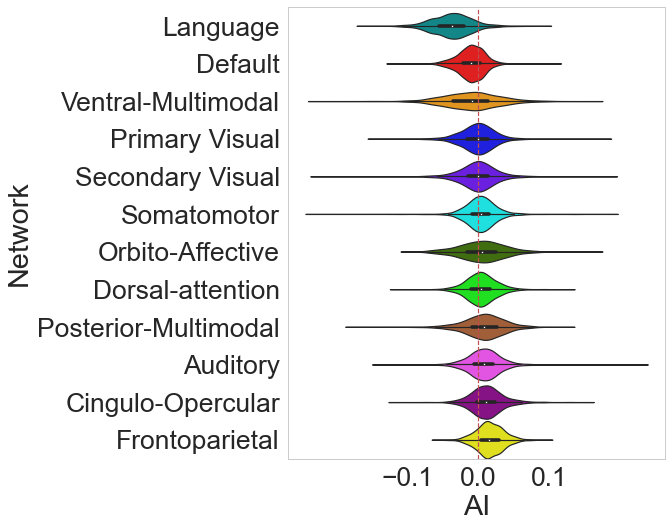

In [33]:
sns.set(rc={'figure.figsize':(10,8)})
sns.set_context("paper", font_scale = 3)
sns.set_style("whitegrid")
ax = sns.violinplot(data = df, x = 'AI',y = 'Network', palette = base_color, width=1)
ax.grid(False)
ax.set_xticks(np.arange(-0.1, 0.15, 0.1))
ax.axvline(x=0, color='r', linestyle='--')
ax.figure.tight_layout()
ax.figure.savefig('../figures/fig_23_ca_intra_g1.svg')

### repeat above CA procedures for inter-hemisphere

In [34]:
inter= [None] * 1014
for i in range(1014):
    inter[i] = np.array(pd.read_csv('../data/data_results/gradient/inter_ca/'+path_list[i],header=None))
inter_g1 = np.array(inter).T[0].T
df_inter = np.concatenate((inter_g1[:,5],inter_g1[:,8],inter_g1[:,10],inter_g1[:,0],
                           inter_g1[:,1],inter_g1[:,2],inter_g1[:,11],inter_g1[:,4],
                           inter_g1[:,9],inter_g1[:,7],inter_g1[:,3],inter_g1[:,6]))
network = np.concatenate((['Language']*1014,['Default']*1014,['Ventral-Multimodal']*1014,
                          ['Primary Visual'] * 1014, ['Secondary Visual'] *1014,['Somatomotor']*1014,
                          ['Orbito-Affective']*1014,['Dorsal-attention']*1014,['Posterior-Multimodal']*1014,
                          ['Auditory']*1014,['Cingulo-Opercular']*1014,['Frontoparietal']*1014))

pd.DataFrame(np.vstack((-df_inter,network)).T, 
             columns = ['AI','Network']).to_csv('../data/data_results/gradient/ca_inter_g1.csv',index=None)

df = pd.read_csv('../data/data_results/gradient/ca_inter_g1.csv')

sts=np.array([stats.ttest_1samp(inter_g1[:,0],0),
 stats.ttest_1samp(inter_g1[:,1],0),
 stats.ttest_1samp(inter_g1[:,2],0),
 stats.ttest_1samp(inter_g1[:,3],0),
 stats.ttest_1samp(inter_g1[:,4],0),
 stats.ttest_1samp(inter_g1[:,5],0),
 stats.ttest_1samp(inter_g1[:,6],0),
 stats.ttest_1samp(inter_g1[:,7],0),
 stats.ttest_1samp(inter_g1[:,8],0),
 stats.ttest_1samp(inter_g1[:,9],0),
 stats.ttest_1samp(inter_g1[:,10],0),
 stats.ttest_1samp(inter_g1[:,11],0)])
sts

array([[ 9.25470506e+00,  1.24216419e-19],
       [ 7.48092257e+00,  1.59760676e-13],
       [-3.49613539e+00,  4.92508114e-04],
       [-1.45753715e+01,  7.91655523e-44],
       [-7.98006319e+00,  3.94018698e-15],
       [ 5.67078892e+00,  1.85339521e-08],
       [-1.20528262e+01,  2.33511899e-31],
       [-5.68545551e+00,  1.70564886e-08],
       [ 1.18736071e+01,  1.54807642e-30],
       [ 1.19093760e+00,  2.33957062e-01],
       [ 1.26976793e+00,  2.04458915e-01],
       [ 4.55974090e+00,  5.74716982e-06]])

In [35]:
fdr(sts[:,1])

array([3.72649257e-19, 3.19521352e-13, 5.91009736e-04, 9.49986628e-43,
       9.45644875e-15, 2.78009282e-08, 1.40107139e-30, 2.92396948e-08,
       6.19230569e-30, 2.33957062e-01, 2.23046089e-01, 7.66289310e-06])

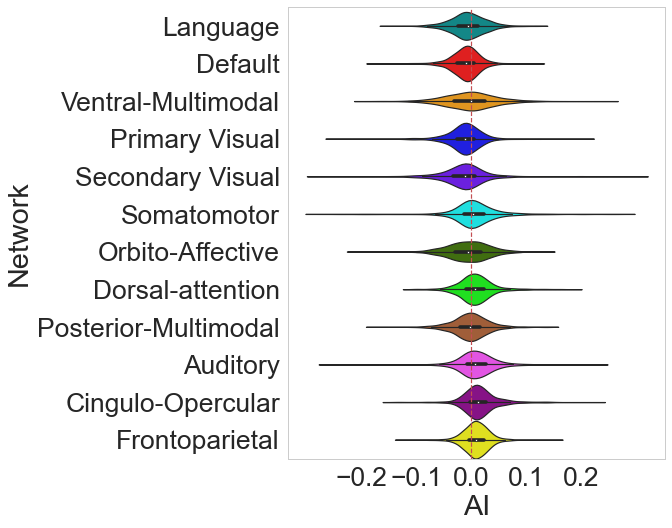

In [36]:
sns.set(rc={'figure.figsize':(10,8)})
sns.set_context("paper", font_scale = 3)
sns.set_style("whitegrid")
ax = sns.violinplot(data = df, x = 'AI',y = 'Network', palette = base_color, width=1)
ax.grid(False)
ax.set_xticks(np.arange(-0.2, 0.3, 0.1))
ax.axvline(x=0, color='r', linestyle='--')
ax.figure.tight_layout()
ax.figure.savefig('../figures/fig_23_ca_inter_g1.svg')